In [63]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import nltk
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to C:\Users\Tim
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tim
[nltk_data]     Lin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
node_info = pd.read_csv('dataset/node_information.csv')
period1 = pd.read_csv('dataset/Period1.csv')
period2 = pd.read_csv('dataset/Period2.csv')
test_data = pd.read_csv('dataset/TestData.csv')
period1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154836 entries, 0 to 154835
Data columns (total 3 columns):
year         154836 non-null int64
source id    154836 non-null int64
target id    154836 non-null int64
dtypes: int64(3)
memory usage: 3.5 MB


In [66]:
def find_unique_node(input_node_set1, input_node_set2):
    node_set = pd.concat([input_node_set1, input_node_set2], ignore_index=True)
    node_set_unique = node_set.loc[node_set.duplicated() == False]
    node_set_unique = node_set_unique.reset_index(drop=True)
    return node_set_unique


period1_node_unique = find_unique_node(period1['source id'], period1['target id'])
period2_node_unique = find_unique_node(period2['source id'], period2['target id'])
period_all_node_unique = find_unique_node(period1_node_unique, period2_node_unique)

# Format edge to newortkx type
period1_edge = [(period1.loc[i, 'source id'], period1.loc[i, 'target id']) for i in range(len(period1))]
period2_edge = [(period2.loc[i, 'source id'], period2.loc[i, 'target id']) for i in range(len(period2))]
period_all_edge = period1_edge + period2_edge


print('period1 ', 'node:', len(period1_node_unique.values), 'edge:', len(period1_edge))
print('period2 ', 'node:', len(period2_node_unique.values), 'edge:', len(period2_edge))
print('period_all ', 'node:', len(period_all_node_unique.values), 'edge:', len(period_all_edge))
print('period_test ', 'node:', len(period_all_node_unique.values), 'edge:', len(period_all_edge))

period1  node: 17028 edge: 154836
period2  node: 15565 edge: 98353
period_all  node: 23237 edge: 253189
period_test  node: 23237 edge: 253189


In [67]:
# Network generate (period1)
network_period1 = nx.Graph()
# Add nodes
network_period1.add_nodes_from(period_all_node_unique.values)
# Add edges
network_period1.add_edges_from(period1_edge)

print('node:', network_period1.number_of_nodes(), 'edge:', network_period1.number_of_edges())

node: 23237 edge: 154698


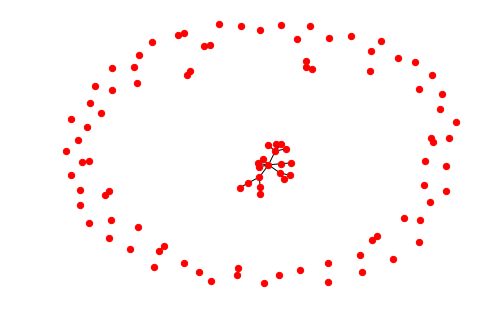

In [68]:
# network graph
sub_graph = network_period1.subgraph(list(period1_node_unique[0:100]))   # 原圖太大取前幾個邊出來畫
pos = nx.spring_layout(sub_graph)  # 圖的畫法
nx.draw(sub_graph, pos=pos, node_size=40, vim=0.0, vmax=1.0, node_color="red")

In [69]:
# Network generate (period_all)
network_all = nx.Graph()
# Add nodes
network_all.add_nodes_from(period_all_node_unique.values)
# Add edges
network_all.add_edges_from(period_all_edge)
print('node:', network_all.number_of_nodes(), 'edge:', network_all.number_of_edges())

node: 23237 edge: 252854


In [70]:
# common neighbor score (neighbor = 1 best)
def common_neighbor(network, input_node1, input_node2): 
    source_neighbor = [n for n in network.neighbors(input_node1)]
    target_neighbor = [n for n in network.neighbors(input_node2)]
    intersection = list(set(source_neighbor) & set(target_neighbor))
    return len(intersection)

# Jaccard's cofficient
def jaccard_cofficient(network, input_node1, input_node2):
    cofficient = 0
    source_neighbor = [n for n in network.neighbors(input_node1)]
    target_neighbor = [n for n in network.neighbors(input_node2)]
    union = list(set(source_neighbor) | set(target_neighbor))
    intersection = list(set(source_neighbor) & set(target_neighbor))
    if len(union) == 0:
        return 0
    else:
        return (len(intersection) / len(union))


# Adamic/Adar
def adamic_adar(network, input_node1, input_node2):
    adamic_score = 0
    source_neighbor = [n for n in network.neighbors(input_node1)]
    target_neighbor = [n for n in network.neighbors(input_node2)]
    intersection = list(set(source_neighbor) & set(target_neighbor))
    
    if len(intersection) == 0:
        return 0
    else:
        for v in intersection:
            adamic_score += 1 / math.log(len([nv for nv in network.neighbors(v)]))
        return adamic_score


# clustering coefficient
def clustering_coefficient(network, input_node):
    node_degree = network.degree[input_node]
    node_triangle = nx.triangles(network, input_node)
    if node_degree - 1 <= 0:
        return 0
    else:
        return (2 * node_triangle) / (node_degree * (node_degree - 1))   
    

# perferential attachment
def perferential_attachment(network, input_node1, input_node2): 
    source_neighbor = len([n for n in network.neighbors(input_node1)])
    target_neighbor = len([n for n in network.neighbors(input_node2)])
    return {'pa_mul': source_neighbor * target_neighbor, 'pa_add': source_neighbor + target_neighbor}

In [71]:
# Katz score
def katz_score(network, input_node1, input_node2, beta=0.005):
    score = 0
    for cutoff in range(1, 5):
        path_amount = 0
        all_paths = nx.all_simple_paths(network, input_node1, input_node2, cutoff=cutoff)
        for path in all_paths:
            if path_amount > 100:
                continue
            else:
                path_amount += 1
                
        score += (beta**cutoff) * path_amount
    return score

In [72]:
# source / target temp diff
def temp_diff(input_node1, input_node2):
    try:
        input_node1_yaer = node_info.loc[node_info['id'] == input_node1]['year'].values[0]
        input_node2_yaer = node_info.loc[node_info['id'] == input_node2]['year'].values[0]
        return abs(input_node1_yaer - input_node2_yaer)
    except:
        return 0


# comm author
def comm_auth(input_node1, input_node2):
    try:
        node1_author = node_info.loc[node_info['id'] == input_node1]['author'].values[0].split(',')
        node2_author = node_info.loc[node_info['id'] == input_node2]['author'].values[0].split(',')
        return len(set(node1_author).intersection(set(node2_author)))
    except:
        return 0


def overlap_title(input_node1, input_node2):
    try:
        node1_title = node_info.loc[node_info['id'] == input_node1]['name'].values[0].lower().split(" ")
        node2_title = node_info.loc[node_info['id'] == input_node2]['name'].values[0].lower().split(" ")
        
        node1_title = [token for token in node1_title if token not in stpwds]
        node1_title = [stemmer.stem(token) for token in node1_title]
        
        node2_title = [token for token in node2_title if token not in stpwds]
        node2_title = [stemmer.stem(token) for token in node2_title]
        
        return len(set(node1_title).intersection(set(node2_title)))
    except:
        return 0
    
    
overlap_title(test_data['source id'][709], test_data['target id'][709])

0

In [73]:
vectorizer=TfidfVectorizer(stop_words="english", max_df=0.01)
corpus = [abstract for abstract in node_info['abstract'].values]
vector_list = vectorizer.fit_transform(corpus)

In [74]:
vector_info = []

for vector in vector_list:
    vector_info.append(vector[:].toarray()[0])

node_info['vector'] = pd.Series(vector_info, index=node_info.index)

In [107]:
def tfidf(node1, node2): 
    try:
        vector1 = node_info.loc[node_info['id'] == node1]['vector'].values[0]
        vector2 = node_info.loc[node_info['id'] == node2]['vector'].values[0]

        temp_cosine=0.0
        if np.linalg.norm(vector1)!=0 and np.linalg.norm(vector2)!=0:
            temp_cosine=cosine(vector1,vector2)
        return temp_cosine
    
    except:
        return 1

In [56]:
max(node_info['vector'][0])

0.40103370083693596

In [81]:
# step 2 geneate model
# find period1 complement graph (使用補圖的所有edge 當training data才對，不過我電腦跑不動)
# network_period1_complement = nx.complement(network_period1)
# print("complement down")

# 直接使用period2裡面的當1，再從network_period1 亂數取幾個點，他們形成的補圖edge當0
# period1 subgraph
period1_not_in_2 = period1_node_unique.append(period2_node_unique).drop_duplicates(keep=False)
period1_node_shuffle = random.Random(2).sample(list(period1_not_in_2), 650)
sub_graph = network_period1.subgraph(period1_node_shuffle)
sub_graph_complement = nx.complement(sub_graph)
# pos = nx.spring_layout(sub_graph)  # 圖的畫法
# nx.draw(sub_graph_complement, pos=pos, node_size=40, vim=0.0, vmax=1.0, node_color="red")


In [82]:
# tag label
train_label = []
# 注意順序
for edge in period2_edge:
    train_label.append(1)
for edge in list(sub_graph_complement.edges()):
    train_label.append(0)   

train_data_edge = period2_edge + list(sub_graph_complement.edges())
train_data = pd.DataFrame(data={'edge': train_data_edge, 'label': train_label})
train_data = shuffle(train_data, random_state=32).reset_index(drop=True)
train_data.head()

,edge,label
0,"(11094, 9812135)",1
1,"(106262, 10223)",1
2,"(6178, 108034)",0
3,"(9805087, 103236)",0
4,"(109122, 108172)",1


In [20]:
# train data feature
cn, jaccard, adamic, cc_mul, cc_add, pa_mul, pa_add = [],[], [], [], [], [], []
katz = []
source_id, target_id = [], []
temp_diff_list, comm_auth_list, overlap_title_list = [], [], []
tfidf_list = []

netwrok_period2 = network_period1
netwrok_period2.add_nodes_from(period2_node_unique)

for edge_id, edge in enumerate(train_data['edge'].values):
    source_id.append(edge[0])
    target_id.append(edge[1])
    
    # neighbor base
    cn.append(common_neighbor(netwrok_period2, edge[0], edge[1]))
    jaccard.append(jaccard_cofficient(netwrok_period2, edge[0], edge[1]))
    adamic.append(adamic_adar(netwrok_period2, edge[0], edge[1]))
    
    # path base
    katz.append(katz_score(netwrok_period2, edge[0], edge[1]))
    # other
    source_cc = clustering_coefficient(netwrok_period2, edge[0])
    target_cc = clustering_coefficient(netwrok_period2, edge[1])
    cc_mul.append(source_cc * target_cc)
    cc_add.append(source_cc + target_cc)
    pa = perferential_attachment(netwrok_period2, edge[0], edge[1])
    pa_mul.append(pa['pa_mul'])
    pa_add.append(pa['pa_add'])
    
    #node_info
    temp_diff_list.append(temp_diff(edge[0], edge[1]))
    comm_auth_list.append(comm_auth(edge[0], edge[1]))
    overlap_title_list.append(overlap_title(edge[0], edge[1]))
    tfidf_list.append(tfidf(edge[0], edge[1]))
    
    if edge_id % 10000 == 0:
        print(edge_id, len(train_data))
# 
train_data['source id'] = pd.Series(source_id, index=train_data.index)
train_data['target id'] = pd.Series(target_id, index=train_data.index)
train_data['cn'] = pd.Series(cn, index=train_data.index)
train_data['jaccard'] = pd.Series(jaccard, index=train_data.index)
train_data['adamic'] = pd.Series(adamic, index=train_data.index)
train_data['cc_mul'] = pd.Series(cc_mul, index=train_data.index)
train_data['cc_add'] = pd.Series(cc_add, index=train_data.index)
train_data['pa_mul'] = pd.Series(pa_mul, index=train_data.index)
train_data['pa_add'] = pd.Series(pa_add, index=train_data.index)
train_data['katz'] = pd.Series(katz, index=train_data.index)
train_data['temp_diff'] = pd.Series(temp_diff_list, index=train_data.index)
train_data['comm_auth'] = pd.Series(comm_auth_list, index=train_data.index)
train_data['overlap_title'] = pd.Series(overlap_title_list, index=train_data.index)
train_data['tfidf'] = pd.Series(tfidf_list, index=train_data.index)
train_data.head(10)

0 199365
10000 199365
20000 199365
30000 199365
40000 199365
50000 199365
60000 199365
70000 199365
80000 199365
90000 199365
100000 199365
110000 199365
120000 199365
130000 199365
140000 199365
150000 199365
160000 199365
170000 199365
180000 199365
190000 199365


,edge,label,source id,target id,cn,jaccard,adamic,shorest_path,cc_mul,cc_add,pa_mul,pa_add
0,"(3273, 9901003)",1,3273,9901003,0,0.0,0.0,0,0.0,0.352632,0,20
1,"(9611207, 6102)",0,9611207,6102,0,0.0,0.0,0,0.0,0.321429,0,8
2,"(10256, 9304002)",0,10256,9304002,0,0.0,0.0,0,0.0,0.000000,0,2
3,"(9061, 9805170)",1,9061,9805170,0,0.0,0.0,0,0.0,0.198859,0,68
4,"(102045, 9901128)",1,102045,9901128,0,0.0,0.0,0,0.0,0.148867,0,103
5,"(9701099, 106212)",0,9701099,106212,0,0.0,0.0,0,0.0,0.358333,0,16
6,"(111284, 9808095)",1,111284,9808095,0,0.0,0.0,0,0.0,0.337662,0,22
7,"(8127, 3220)",1,8127,3220,0,0.0,0.0,0,0.0,0.000000,0,0
8,"(107149, 9806106)",1,107149,9806106,0,0.0,0.0,0,0.0,0.148148,0,27
9,"(4186, 9804123)",1,4186,9804123,0,0.0,0.0,0,0.0,0.211429,0,50


In [21]:
#save train data
train_data_bye = train_data.drop('edge', axis=1)
train_data_bye.to_csv("train_data_real_sp.csv", index=False)

In [90]:
#load train data
train_data = pd.read_csv("train_data_650.csv")

In [92]:
# train feature (pa_add 爛
feature = zip(train_data['cn'], train_data['jaccard'], train_data['adamic'], train_data['cc_mul'], train_data['cc_add'],
              train_data['pa_mul'], train_data['katz'], train_data['temp_diff'], train_data['comm_auth'],
              train_data['overlap_title'], train_data['tfidf'])

feature = [[cn, jaccard, adamic, cc_mul, cc_add, pa_mul, katz, td, ca, ot, tfidf]
           for cn, jaccard, adamic, cc_mul, cc_add, pa_mul, katz, td, ca, ot, tfidf in feature]

In [10]:
#SVM gogo
svm = SVC()
svm.fit(feature, train_data['label'].tolist())


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
svm.predict([[0, 0, 0, 0, 0]])

ValueError: X.shape[1] = 5 should be equal to 7, the number of features at training time

In [93]:
# Decision tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(feature, train_data['label'].tolist())

In [46]:
# Random forest
rf = RandomForestClassifier(random_state=0, n_estimators=300)
rf = rf.fit(feature, train_data['label'].tolist())

In [13]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(feature, train_data['label'].tolist())

In [96]:
# step 3 link predict
# check test data is in network
test_data_node_unique = find_unique_node(test_data['source id'], test_data['target id'])
test_data_in_network = pd.concat([period_all_node_unique, test_data_node_unique], ignore_index=True)
test_data_in_network = test_data_in_network.loc[test_data_in_network.duplicated() == True]
test_data_in_network = test_data_in_network.reset_index(drop=True)


# Add test data node & edge in network
test_edge = [(test_data.loc[i, 'source id'], test_data.loc[i, 'target id']) for i in range(len(test_data))]
network_test = network_all
network_test.add_nodes_from(test_data_node_unique.values)
# network_test.add_edges_from(test_edge)

print('period_test ', 'node:', network_test.number_of_nodes(), 'edge:', network_test.number_of_edges())

period_test  node: 31491 edge: 252854


In [97]:
# test data feature 
neighbor_score_list = []
for data_id, data in test_data.iterrows():
    neighbor_score_list.append(common_neighbor(network_test, data['source id'], data['target id']))
    
print(neighbor_score_list[709])

5


In [98]:
jaccard_score_list = []
    
for data_id, data in test_data.iterrows():
    jaccard_score_list.append(jaccard_cofficient(network_test, data['source id'], data['target id']))
        
# Networkx jaccard_coefficient function
# networkx_jaccard = []
# fucking_list = []
# 
# for data_id, data in test_data.iterrows():
#     fucking_list.append(((data['source id'],data['target id'])))
#     
# preds = nx.jaccard_coefficient(network_all, fucking_list)
# for u,v,p in preds:
#     networkx_jaccard.append(p)
# 
# print(networkx_jaccard[709])
print(jaccard_score_list[709])

0.07692307692307693


In [99]:
adamic_score_list = []
for data_id, data in test_data.iterrows():
    adamic_score_list.append(adamic_adar(network_test, data['source id'], data['target id']))   


# Networkx adamic_adar_index
# networkx_adamic_adar_index = []
# fucking_list = []
# 
# for data_id, data in test_data.iterrows():
#     fucking_list.append(((data['source id'],data['target id'])))
# 
# preds = nx.adamic_adar_index(network_all, fucking_list)
# for u, v, p in preds:
#     networkx_adamic_adar_index.append(p)
#     
# print(networkx_adamic_adar_index[709])
print(adamic_score_list[709])

1.2312765119577431


In [100]:
cc_mul_score_list = []
cc_add_scroe_list = []
for data_id, data in test_data.iterrows():
    source_cc = clustering_coefficient(network_test, data['source id'])
    target_cc = clustering_coefficient(network_test, data['target id'])
    cc_mul_score_list.append(source_cc * target_cc) 
    cc_add_scroe_list.append(source_cc + target_cc)
    
# Networkx cc
# networkx_cc = []
# for data_id, data in test_data.iterrows():
#     cc_score = nx.clustering(network_test, data['source id']) * nx.clustering(network_test, data['target id'])
#     networkx_cc.append(cc_score)
# 
# print(networkx_cc[709])

print(cc_add_scroe_list[709])


1.0617702448210922


In [101]:
pa_mul_score_list = []
pa_add_scroe_list = []
for data_id, data in test_data.iterrows():
    pa = perferential_attachment(network_test, data['source id'], data['target id'])
    pa_mul_score_list.append(pa['pa_mul'])
    pa_add_scroe_list.append(pa['pa_add'])

print(pa_mul_score_list[709])

600


In [102]:
sp_score_list = []

for data_id, data in test_data.iterrows():
    try:
        sp_score_list.append(nx.shortest_path_length(network_period1, edge[0], edge[1]))
    except:
        sp_score_list.append(0)
        
print(sp_score_list[709])

0


In [103]:
katz_score_list = []
for data_id, data in test_data.iterrows():
    katz = katz_score(network_test, data['source id'], data['target id'])
    katz_score_list.append(katz)

In [104]:
temp_diff_list, comm_auth_list, overlap_title_list = [], [], []

for data_id, data in test_data.iterrows():
    temp_diff_list.append(temp_diff(data['source id'], data['target id']))
    comm_auth_list.append(comm_auth(data['source id'], data['target id']))
    overlap_title_list.append(overlap_title(data['source id'], data['target id']))

In [108]:
tfidf_list = []
for data_id, data in test_data.iterrows():
    tfidf_list.append(tfidf(data['source id'], data['target id']))

In [110]:
# predict test data dt
test_feature = [[n, j, a, cc_mul, cc_add, pa_mul, katz, td, ca, ot, tfidf] for n, j, a, cc_mul, cc_add, pa_mul, katz, td, ca, ot, tfidf in 
                zip(neighbor_score_list, jaccard_score_list, adamic_score_list, cc_mul_score_list, cc_add_scroe_list,
                    pa_mul_score_list, katz_score_list, temp_diff_list, comm_auth_list, overlap_title_list, tfidf_list)]

predict = dt.predict(test_feature)
print(len(predict))

10000


In [111]:
# output predict
row = [i for i in range(1, 10001)]
label = predict

data = {'target id': row, 'label': label}
predict = pd.DataFrame(data=data, columns=['target id', 'label'])
predict.to_csv("predict/dt_tfidf.csv", index=False)
